**bold text**<h2>"Sign Langauge Recognition"</h2>

This is Transfer Learning on Sign Language Recognition.

Firstly, we import all neccessary modules.


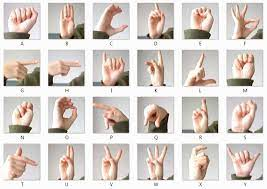

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import seaborn as sns
import pandas as pd
from torchvision.transforms import Resize, ToTensor

<h2>Training and Test Set is of size (27455, 785) where 1 columns are taken by label, so there are basically 784 pixels as illustrated below


In [22]:
from google.colab import drive
drive.mount('/content/drive/')

pd.set_option('display.max_rows', 29)


train = pd.read_csv('/content/drive/MyDrive/Sign Language Reco/Sign Language Reco/sign_mnist_train.csv')
test = pd.read_csv('/content/drive/MyDrive/Sign Language Reco/Sign Language Reco/sign_mnist_test.csv')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train.head(10)

mapping = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:"f", 6:'g', 7:'h', 8:'i', 9:'j', 10:'k', 11:'l', 12:'m', 13:'n',
        14:'o', 15:'p', 16:'q', 17:'r', 18:'s', 19:'t', 20:'u', 21:'v', 22:'w', 23:'x', 24:'y', 25:'z'}

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


<h2>Shape of Image_final is (27455, 28 , 28), here 784 pixel is converted into 28x28:

In [23]:
text="pixel"
images=torch.zeros((train.shape[0],1)) #Making row tensor with all entries 0
for i in range(1,785):
    temp_text=text+str(i)
    temp=train[temp_text]
    temp=torch.FloatTensor(temp).unsqueeze(1) #Just making a row tensor with pixel<i> from csv file by putting all the values of column pixel<i>
    images=torch.cat((images,temp),1) #Here Concatenates image tensor with temp tensor along axis 1
images_final=torch.FloatTensor(images[:,1:]).view(-1,28,28) #all rows included, and column containing ,zero discarded and taken up all other columns and view in 28*28

label = train["label"]
label = torch.FloatTensor(label).unsqueeze(1)


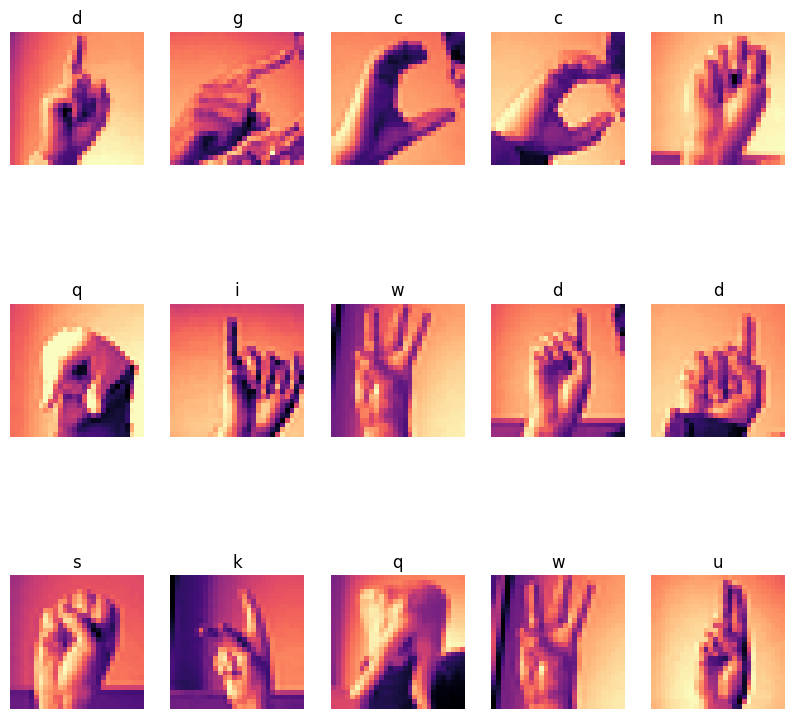

In [24]:
fig = plt.figure(figsize=(10, 10))
columns = 5
rows = 3

for i in range(15):
    img = images_final[i, :]
    img = img.numpy()
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(img, cmap='magma')
    plt.title(f'{mapping[int(label[i])]}')
    plt.axis('off')

plt.show()


In [25]:
class GestureDataset(Dataset):
    def __init__(self, csv, transform=None):
        self.csv = pd.read_csv(csv)
        self.transform = transform

    def __getitem__(self, index):
        img = self.csv.iloc[index, 1:].values.astype(np.uint8).reshape((28, 28))
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        label = self.csv.iloc[index, 0]
        return img, label

    def __len__(self):
        return len(self.csv)

##Data Loading of Train, Validation

In [26]:
transform = transforms.Compose([
    Resize((224, 224)),
    ToTensor(),
])

train_dataset = GestureDataset('/content/drive/MyDrive/Sign Language Reco/Sign Language Reco/sign_mnist_train.csv', transform=transform)
val_dataset = GestureDataset('/content/drive/MyDrive/Sign Language Reco/Sign Language Reco/sign_mnist_test.csv', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)

dataset_ = {"train": train_loader, "val": val_loader}


In [27]:
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs, device=device):
      training_loss=[]
      training_accuracy=[]
      val_loss=[]
      val_accuracy=[]
      since = time.time()

      best_model_wts = copy.deepcopy(model.state_dict())
      best_acc = 0.0
      model.to(device)

      for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'val']:
          if phase == 'train':
            model.train()
          else:
            model.eval()

          running_loss = 0.0
          running_corrects = 0

          for inputs, labels in dataset_[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == 'train'):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)
              if phase == 'train':
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
          if phase == 'train':
            scheduler.step()

          epoch_loss = running_loss / len(dataset_[phase].dataset)
          epoch_acc = running_corrects.double() / len(dataset_[phase].dataset)

          if phase=='train':
            training_loss.append(epoch_loss)
            training_accuracy.append(epoch_acc)

          elif phase=='val':
            val_loss.append(epoch_loss)
            val_accuracy.append(epoch_acc)


          print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))

          # deep copy the model
          if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

      time_elapsed = time.time() - since
      print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
      print('Best val Acc: {:4f}'.format(best_acc))

      model.load_state_dict(best_model_wts)
      return model,training_accuracy,training_loss,val_accuracy,val_loss

In [28]:
model_ft = models.mobilenet_v2(pretrained=True).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:

model_ft.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, 26)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
print(model_ft)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=2)

Epoch 0/1
----------
train Loss: 1.2739 Acc: 0.7442
val Loss: 0.3532 Acc: 0.9591

Epoch 1/1
----------
train Loss: 0.1040 Acc: 0.9974
val Loss: 0.0759 Acc: 0.9965

Training complete in 4m 14s
Best val Acc: 0.996514


In [71]:
import torchvision.models.quantization as models_quant

model_ft = models_quant.mobilenet_v2(pretrained=True)

model_ft.eval()
quantized_model = torch.quantization.quantize_dynamic(
    model_ft,  # Original model
    {torch.nn.Linear, torch.nn.Conv2d},  # Desired layer types to quantize
    dtype=torch.qint8  # Target data type for quantized weights and activations
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
quantized_model = quantized_model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [72]:
quantized_model = quantized_model.cpu()
torch.quantization.convert(quantized_model, inplace=True)


QuantizableMobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): QuantizableInvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (skip_add): FloatFunctional(
        (activation_post_process): Identity()
      )
    )
    (2): QuantizableInvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): C

###Saving the Model

In [73]:
FILE = 'Sign_language_reco_model_MobileNet.pth'
torch.save(model_ft,FILE)

FILE2 = 'QuantMobileNet(sign_language_reco).pth'
torch.save(quantized_model,FILE2)

##Loading the model

In [74]:
quant_loaded = models.mobilenet_v2()
quant_loaded = torch.load('/content/QuantMobileNet(sign_language_reco).pth')
quant_loaded.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
num_ftrs = quant_loaded.classifier[1].in_features
quant_loaded.classifier[1] = nn.Linear(num_ftrs, 26)

quant_loaded.eval()

QuantizableMobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): QuantizableInvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (skip_add): FloatFunctional(
        (activation_post_process): Identity()
      )
    )
    (2): QuantizableInvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): C

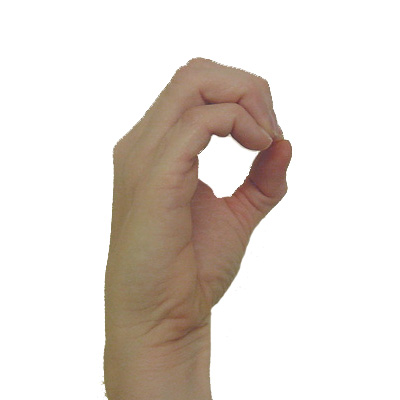

Predicted Class Index: o


In [91]:
import IPython.display as display
import torchvision.transforms as transforms
from PIL import Image

# Define the device (GPU or CPU) based on availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the quantized model from the saved file (assuming you've already loaded the model)
# quant_loaded = torch.load('/path/to/quantized_model.pth')

# Assuming you have defined and loaded the quantized model
# Set the model to evaluation mode
quant_loaded.eval()

# Define a transformation to preprocess your input data (e.g., resizing and normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Assuming MobileNet input size is 224x224
    transforms.Grayscale(num_output_channels=1),  # Convert to single-channel (grayscale)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])  # Grayscale normalization values
])

# Load and preprocess the image you want to classify
image_path = '/content/O.jpg'
image = Image.open(image_path)
display.display(image)
input_tensor = transform(image)
input_batch = input_tensor.unsqueeze(0)

# Move the input data to the device (GPU or CPU)
input_batch = input_batch.to(device)

# Perform inference by passing the input data through the quantized model
with torch.no_grad():
    output = quant_loaded.to(device)(input_batch)
probabilities = nn.functional.softmax(output[0], dim=0)

predicted_class_idx = torch.argmax(probabilities).item()

# Print the class index and corresponding probability
print("Predicted Class Index:", mapping[predicted_class_idx])

